<h1 style="color:#D40078; font-weight:bold;">White Blood Cell Classification:</h1>  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Resizing, RandomFlip, RandomRotation, RandomBrightness
import tensorflow as tf
from tensorflow.keras.utils import img_to_array, load_img, array_to_img
from sklearn.model_selection import train_test_split
from transformers import ViTImageProcessor, ViTForImageClassification
import requests
import numpy as np
import torch
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import copy
import keras
from keras.layers import Dense, GlobalAveragePooling2D
from datasets import ClassLabel, Dataset, Features, Sequence, DatasetDict

<h1 style="color:#D40078; font-weight:bold;">Data Preprocessing:</h1>  

In [3]:
zip_path = '/content/drive/My Drive/NN&DL/hw5/Q2/Q2_Data.zip'

extract_to = 'data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extracted files:", os.listdir(extract_to))

Extracted files: ['MONOCYTE', 'NEUTROPHIL', 'EOSINOPHIL', 'LYMPHOCYTE']


In [ ]:
Eosinophil_path = os.path.join(extract_to, 'EOSINOPHIL/BloodImage_00009.jpg')
Lymphocyte_path = os.path.join(extract_to, 'LYMPHOCYTE/BloodImage_00020.jpg')
Monocyte_path = os.path.join(extract_to, 'MONOCYTE/BloodImage_00127.jpg')
Neutrophil_path = os.path.join(extract_to, 'NEUTROPHIL/BloodImage_00263.jpg')

def show_images(Eosinophil_path, Lymphocyte_path, Monocyte_path, Neutrophil_path):

  fig, ax = plt.subplots(1, 4, figsize=(10, 5))

  ax[0].imshow(Image.open(Eosinophil_path))
  ax[0].set_title("Eosinophil")
  ax[0].axis("off")

  ax[1].imshow(Image.open(Lymphocyte_path))
  ax[1].set_title("Lymphocyte")
  ax[1].axis("off")

  ax[2].imshow(Image.open(Monocyte_path))
  ax[2].set_title("Monocyte")
  ax[2].axis("off")

  ax[3].imshow(Image.open(Neutrophil_path))
  ax[3].set_title("Neutrophil")
  ax[3].axis("off")

  plt.tight_layout()
  plt.show()

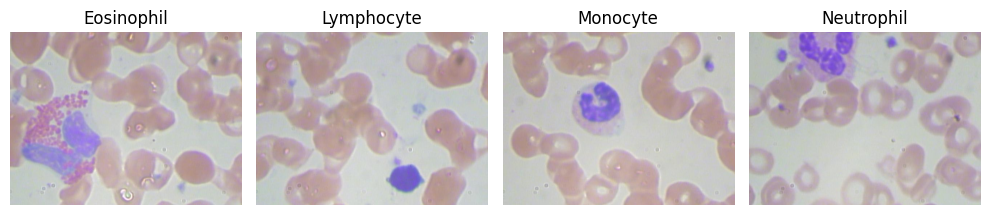

In [ ]:
show_images(Eosinophil_path, Lymphocyte_path, Monocyte_path, Neutrophil_path)

In [6]:
def count_images(dir_path):
  title = os.path.basename(dir_path).title()
  count = 0
  for path in os.scandir(dir_path):
      if path.is_file():
          count += 1
  result = " ".join(["There are", str(count), "images of", title, "white blood cells."])
  print(result)

count_images('data/EOSINOPHIL')
count_images('data/LYMPHOCYTE')
count_images('data/MONOCYTE')
count_images('data/NEUTROPHIL')

There are 88 images of Eosinophil white blood cells.
There are 33 images of Lymphocyte white blood cells.
There are 20 images of Monocyte white blood cells.
There are 206 images of Neutrophil white blood cells.


In [4]:
data_transform = Sequential([
    Resizing(224, 224, interpolation="bilinear"),
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomBrightness(factor=0.3),
])

In [5]:
def data_augmentation(data_dir, number_of_images, data_transform):
  image_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith(".jpg")]

  images_needed = number_of_images - len(image_paths)

  for i in range(number_of_images - len(image_paths)):

    path = image_paths[i % len(image_paths)]

    image = load_img(path, target_size=(224, 224))
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

    augmented_image_tensor = data_transform(image_tensor)
    augmented_image = array_to_img(augmented_image_tensor)
    
    augmented_image.save(f"{os.path.splitext(path)[0]}_augment_{i}.jpg")


In [7]:
data_augmentation('data/EOSINOPHIL', 210, data_transform)
count_images('data/EOSINOPHIL')

There are 210 images of Eosinophil white blood cells.


In [8]:
data_augmentation('data/LYMPHOCYTE', 210, data_transform)
count_images('data/LYMPHOCYTE')

There are 210 images of Lymphocyte white blood cells.


In [9]:
data_augmentation('data/MONOCYTE', 210, data_transform)
count_images('data/MONOCYTE')

There are 210 images of Monocyte white blood cells.


In [10]:
data_augmentation('data/NEUTROPHIL', 210, data_transform)
count_images('data/NEUTROPHIL')

There are 210 images of Neutrophil white blood cells.


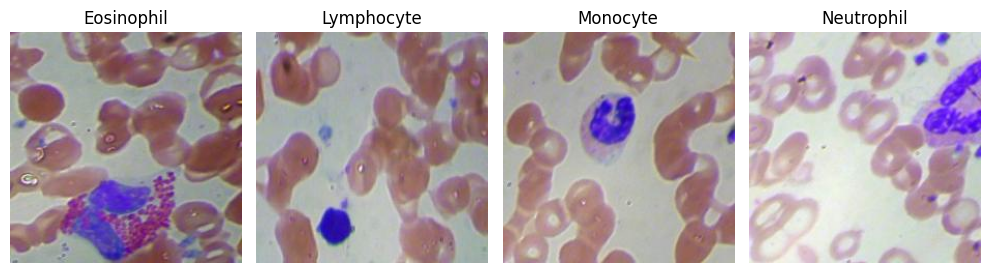

In [ ]:
Eosinophil_aug = os.path.join(extract_to, 'EOSINOPHIL/BloodImage_00009_augment_100.jpg')
Lymphocyte_aug = os.path.join(extract_to, 'LYMPHOCYTE/BloodImage_00020_augment_124.jpg')
Monocyte_aug = os.path.join(extract_to, 'MONOCYTE/BloodImage_00127_augment_103.jpg')
Neutrophil_aug = os.path.join(extract_to, 'NEUTROPHIL/BloodImage_00263_augment_3.jpg')

show_images(Eosinophil_aug, Lymphocyte_aug, Monocyte_aug, Neutrophil_aug)

In [ ]:
def plot_bras(labels):
  class_0 = np.sum(labels == 0)
  class_1 = np.sum(labels == 1)
  class_2 = np.sum(labels == 2)
  class_3 = np.sum(labels == 3)

  colors = ["pink", "khaki", "thistle", "skyblue"]
  frequancy = [class_0, class_1, class_2, class_3]
  label = ["Eosinophil", "Lymphocyte", "Monocyte", "NEUTROPHIL"]
  bars = plt.bar(label, frequancy, color=colors, width=0.5 )

  for bar in bars:
      plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{int(bar.get_height())}',
              ha='center', va='bottom', fontsize=8, fontweight='bold', color='black')

  plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
  plt.grid(axis='x', linestyle='--', linewidth=0.7, alpha=0.7)

  plt.title('Different Classes')
  plt.ylabel("Frequancy")
  plt.show()

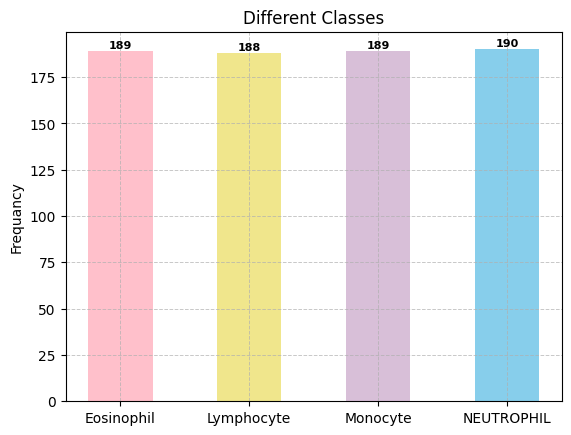

In [ ]:
plot_bras(np.array(y_train))

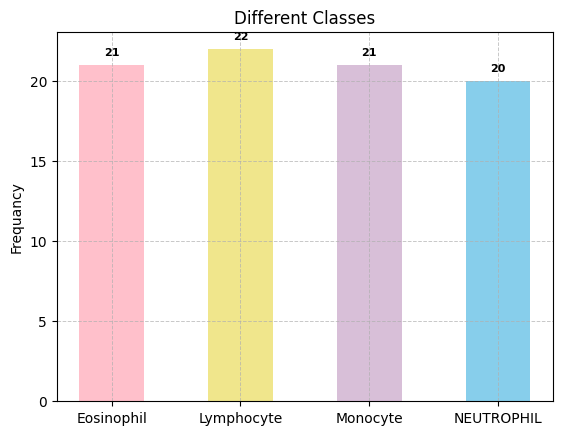

In [ ]:
plot_bras(np.array(y_val))

In [11]:
dataset = {"images": [], "image_file_path": [], "labels": []}

def create_dataset(data_dir, label, dataset):

  image_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith(".jpg")]

  for path in image_paths:

      image = load_img(path)
      dataset["images"].append(image)
      dataset["image_file_path"].append(path)
      dataset["labels"].append(label)

  return dataset

dataset = create_dataset('data/EOSINOPHIL', 0, dataset)
dataset = create_dataset('data/LYMPHOCYTE', 1, dataset)
dataset = create_dataset('data/MONOCYTE', 2, dataset)
dataset = create_dataset('data/NEUTROPHIL', 3, dataset)


In [12]:
images = dataset["images"]
labels = dataset["labels"]

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

In [16]:
ds_train = Dataset.from_dict({"image": X_train, "label": y_train})
ds_validation = Dataset.from_dict({"image": X_val, "label": y_val})

ds = DatasetDict({"train": ds_train, "validation": ds_validation})

<h1 style="color:#D40078; font-weight:bold;">VisionTransformer(ViT) Model:</h1>  

In [18]:
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTImageProcessor.from_pretrained(model_name)

In [ ]:
feature_extractor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [19]:
def transform(example):

  inputs = feature_extractor([x for x in example["image"]], return_tensors='pt')

  inputs["labels"] = torch.tensor(example["label"])

  return inputs

In [20]:
prepared_ds = ds.with_transform(transform)

In [ ]:
prepared_ds["train"][0]

{'pixel_values': tensor([[[0.4039, 0.4588, 0.5137,  ..., 0.4745, 0.4745, 0.4745],
          [0.3882, 0.4510, 0.5059,  ..., 0.4667, 0.4667, 0.4667],
          [0.3569, 0.4353, 0.4902,  ..., 0.4588, 0.4588, 0.4588],
          ...,
          [0.4824, 0.4824, 0.4510,  ..., 0.4118, 0.4039, 0.3882],
          [0.4745, 0.4667, 0.4353,  ..., 0.3882, 0.3882, 0.3725],
          [0.4667, 0.4588, 0.4196,  ..., 0.3725, 0.3725, 0.3569]],
 
         [[0.3176, 0.3961, 0.4824,  ..., 0.4745, 0.4745, 0.4745],
          [0.3020, 0.3961, 0.4745,  ..., 0.4745, 0.4667, 0.4667],
          [0.2784, 0.3882, 0.4667,  ..., 0.4667, 0.4667, 0.4667],
          ...,
          [0.3255, 0.3333, 0.3098,  ..., 0.2157, 0.2157, 0.2078],
          [0.3098, 0.3255, 0.2941,  ..., 0.2000, 0.2078, 0.2000],
          [0.3098, 0.3098, 0.2784,  ..., 0.1765, 0.1922, 0.1922]],
 
         [[0.4353, 0.4353, 0.4353,  ..., 0.4431, 0.4667, 0.4745],
          [0.4039, 0.4118, 0.4118,  ..., 0.4353, 0.4588, 0.4667],
          [0.3490, 0.380

In [ ]:
z = prepared_ds["train"][20]["pixel_values"]
print(z.shape)

torch.Size([3, 224, 224])


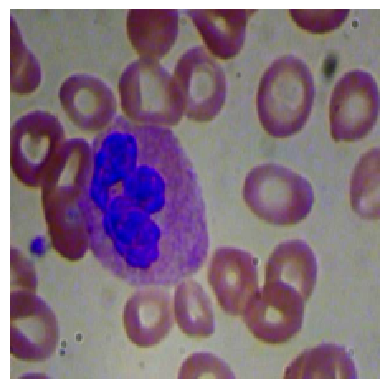

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.axis("off")
    plt.show()
show(z)

In [21]:
train_loader = DataLoader(prepared_ds["train"], batch_size=16, shuffle=True)
val_loader = DataLoader(prepared_ds["validation"], batch_size=16)

In [22]:
def plot_loss_acc(loss, val_loss, accuracy, val_accuracy):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  ax[0].plot(range(1, epochs+1), loss, label='train loss', marker='o')
  ax[0].plot(range(1, epochs+1), val_loss, label='val loss', marker='o')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Train Loss vs Val Loss')
  ax[0].legend()
  ax[0].grid()

  ax[1].plot(range(1, epochs+1), accuracy, label='train accuracy', marker='o')
  ax[1].plot(range(1, epochs+1), val_accuracy, label='val accuracy', marker='o')

  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Train Accuracy vs Val Accuracy')
  ax[1].legend()
  ax[1].grid()

  plt.tight_layout()
  plt.show()

In [23]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device):
  true_train = 0
  total_train = 0
  true_val = 0
  total_val = 0
  running_train_loss = 0
  running_val_loss = 0

  model.train()
  for batch in train_loader:

    images = batch["pixel_values"].to(device)
    labels = batch["labels"].to(device)

    optimizer.zero_grad()
    output = model(images).logits

    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_train_loss += loss.item()
    _, predicted = torch.max(output, dim=1)

    total_train += labels.size(0)
    true_train += (predicted == labels).sum().item()

  train_loss = running_train_loss/len(train_loader)
  train_acc = 100 * true_train / total_train

  model.eval()
  with torch.no_grad():
    for batch in val_loader:

        images = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        output = model(images).logits
        loss = criterion(output, labels)
        running_val_loss += loss.item()
        _, predicted = torch.max(output, dim=1)
        total_val += labels.size(0)
        true_val += (predicted == labels).sum().item()

  val_loss  = running_val_loss/len(val_loader)
  val_acc =  100 * true_val / total_val

  return train_loss, train_acc, val_loss, val_acc

In [24]:
def run_model(model, train_loader, val_loader, optimizer, criterion, epochs, device):
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []
  test_loss = []
  test_acc = []

  for epoch in range(epochs):
    t_loss, t_acc, v_loss, v_acc = train_model(model, train_loader, val_loader, optimizer, criterion, device)
    train_loss.append(t_loss)
    train_acc.append(t_acc)
    val_loss.append(v_loss)
    val_acc.append(v_acc)

    print(f'Epoch[{epoch+1}/{epochs}]------ accuracy: {t_acc:.2f}% ------ loss:{t_loss:.2f}------ val_accuracy: {v_acc:.2f}% ------ val_loss: {v_loss:.2f}')

  return train_loss, train_acc, val_loss, val_acc

In [25]:
id2label = {
    0 : 'Eosinophil',
    1: 'Lymphocyte',
    2: 'Monocyte',
    3: 'Neutrophil'
}
label2id = {v: k for k, v in id2label.items()}

In [27]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [29]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=4,
    id2label=id2label,
    label2id=label2id,

)

print(f"Trainable parameters: {count_trainable_parameters(model)}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 85801732


In [ ]:
def train_classifier_layer(model):
  model1 = copy.deepcopy(model)
  for layer in model1.base_model.parameters():
    layer.requires_grad = False

  for param in model1.classifier.parameters():
      param.requires_grad = True

  return model1

model_1 = train_classifier_layer(model)
print(f"Trainable parameters: {count_trainable_parameters(model_1)}")


Trainable parameters: 3076


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_1.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr = 1e-4)
epochs = 10

In [ ]:
train_loss, train_acc, val_loss, val_acc = run_model(model_1, train_loader, val_loader, optimizer, criterion, epochs, device)

Epoch[1/10]------ accuracy: 33.07% ------ loss:1.38------ val_accuracy: 44.05% ------ val_loss: 1.36
Epoch[2/10]------ accuracy: 56.48% ------ loss:1.33------ val_accuracy: 55.95% ------ val_loss: 1.31
Epoch[3/10]------ accuracy: 64.02% ------ loss:1.28------ val_accuracy: 67.86% ------ val_loss: 1.27
Epoch[4/10]------ accuracy: 67.72% ------ loss:1.23------ val_accuracy: 65.48% ------ val_loss: 1.23
Epoch[5/10]------ accuracy: 67.86% ------ loss:1.20------ val_accuracy: 67.86% ------ val_loss: 1.20
Epoch[6/10]------ accuracy: 68.78% ------ loss:1.16------ val_accuracy: 67.86% ------ val_loss: 1.17
Epoch[7/10]------ accuracy: 68.39% ------ loss:1.13------ val_accuracy: 67.86% ------ val_loss: 1.14
Epoch[8/10]------ accuracy: 70.11% ------ loss:1.10------ val_accuracy: 70.24% ------ val_loss: 1.11
Epoch[9/10]------ accuracy: 70.24% ------ loss:1.07------ val_accuracy: 70.24% ------ val_loss: 1.08
Epoch[10/10]------ accuracy: 71.16% ------ loss:1.04------ val_accuracy: 70.24% ------ val_

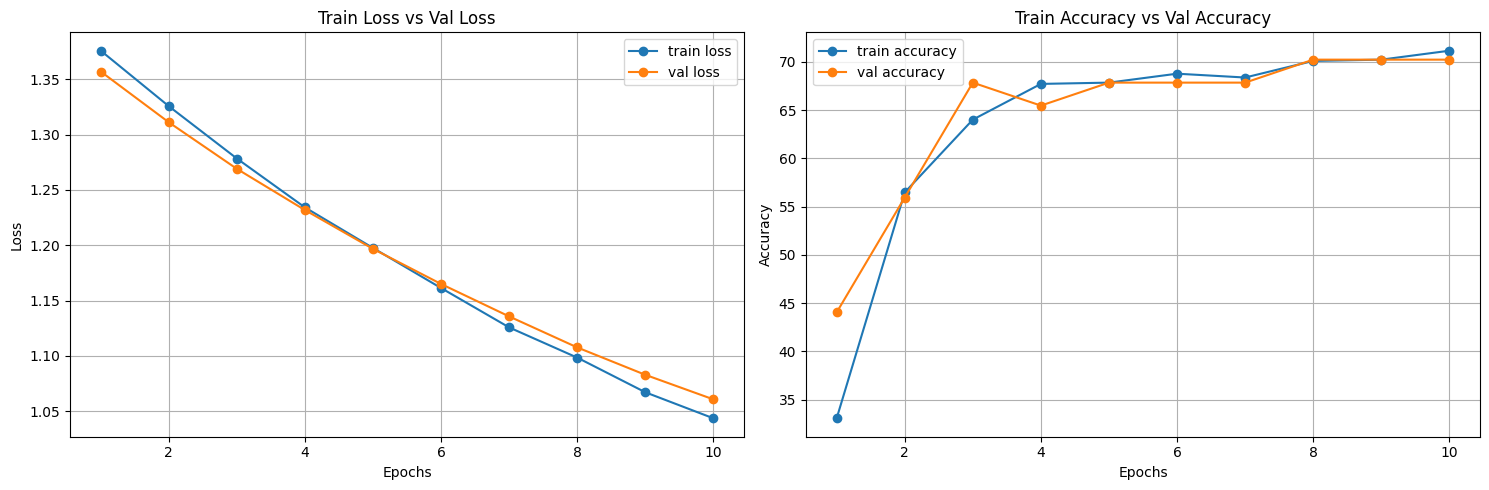

In [ ]:
plot_loss_acc(train_loss, val_loss, train_acc, val_acc)

In [ ]:
def train_first_two_encoder_layer(model):
  model2 = copy.deepcopy(model)
  model2 = train_classifier_layer(model)
  for i in range(2):
      for param in model2.base_model.encoder.layer[i].parameters():
          param.requires_grad = True
  return model2

model_2 = train_first_two_encoder_layer(model)
model_2.to(device)
print(f"Trainable parameters: {count_trainable_parameters(model_2)}")

Trainable parameters: 14178820


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr = 1e-4)

In [ ]:
train_loss_2, train_acc_2, val_loss_2, val_acc_2 = run_model(model_2, train_loader, val_loader, optimizer_2, criterion, epochs, device)

Epoch[1/10]------ accuracy: 53.44% ------ loss:1.28------ val_accuracy: 64.29% ------ val_loss: 1.13
Epoch[2/10]------ accuracy: 80.82% ------ loss:0.97------ val_accuracy: 82.14% ------ val_loss: 0.82
Epoch[3/10]------ accuracy: 91.14% ------ loss:0.69------ val_accuracy: 88.10% ------ val_loss: 0.61
Epoch[4/10]------ accuracy: 96.16% ------ loss:0.45------ val_accuracy: 92.86% ------ val_loss: 0.46
Epoch[5/10]------ accuracy: 98.54% ------ loss:0.29------ val_accuracy: 88.10% ------ val_loss: 0.45
Epoch[6/10]------ accuracy: 99.87% ------ loss:0.19------ val_accuracy: 92.86% ------ val_loss: 0.30
Epoch[7/10]------ accuracy: 100.00% ------ loss:0.13------ val_accuracy: 92.86% ------ val_loss: 0.23
Epoch[8/10]------ accuracy: 100.00% ------ loss:0.10------ val_accuracy: 94.05% ------ val_loss: 0.21
Epoch[9/10]------ accuracy: 100.00% ------ loss:0.07------ val_accuracy: 95.24% ------ val_loss: 0.20
Epoch[10/10]------ accuracy: 100.00% ------ loss:0.06------ val_accuracy: 94.05% ------ 

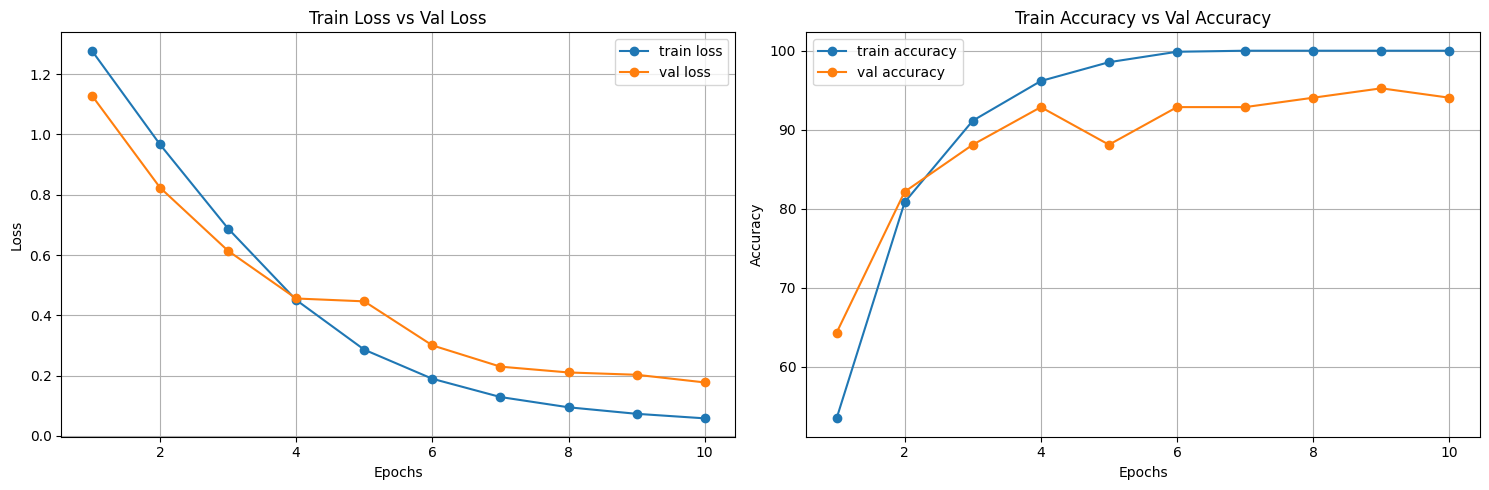

In [ ]:
plot_loss_acc(train_loss_2, val_loss_2, train_acc_2, val_acc_2)

In [ ]:
def train_last_two_encoder_layer(model):
  model3 = copy.deepcopy(model)
  model3 = train_classifier_layer(model)
  encoder_layers = len(model3.base_model.encoder.layer)
    
  for i in range(encoder_layers-2, encoder_layers):

    for param in model3.base_model.encoder.layer[i].parameters():
        param.requires_grad = True

  return model3
model_3 = train_last_two_encoder_layer(model)
model_3.to(device)
print(f"Trainable parameters: {count_trainable_parameters(model_3)}")

Trainable parameters: 14178820


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_3 = optim.Adam(model_3.parameters(), lr = 1e-4)

In [ ]:
train_loss_3, train_acc_3, val_loss_3, val_acc_3 = run_model(model_3, train_loader, val_loader, optimizer_3, criterion, epochs, device)

Epoch[1/10]------ accuracy: 68.52% ------ loss:1.01------ val_accuracy: 84.52% ------ val_loss: 0.63
Epoch[2/10]------ accuracy: 89.15% ------ loss:0.42------ val_accuracy: 91.67% ------ val_loss: 0.29
Epoch[3/10]------ accuracy: 93.78% ------ loss:0.23------ val_accuracy: 92.86% ------ val_loss: 0.25
Epoch[4/10]------ accuracy: 96.16% ------ loss:0.17------ val_accuracy: 86.90% ------ val_loss: 0.24
Epoch[5/10]------ accuracy: 97.35% ------ loss:0.11------ val_accuracy: 94.05% ------ val_loss: 0.18
Epoch[6/10]------ accuracy: 98.68% ------ loss:0.08------ val_accuracy: 92.86% ------ val_loss: 0.17
Epoch[7/10]------ accuracy: 98.15% ------ loss:0.07------ val_accuracy: 94.05% ------ val_loss: 0.19
Epoch[8/10]------ accuracy: 98.41% ------ loss:0.07------ val_accuracy: 95.24% ------ val_loss: 0.16
Epoch[9/10]------ accuracy: 99.60% ------ loss:0.04------ val_accuracy: 95.24% ------ val_loss: 0.14
Epoch[10/10]------ accuracy: 100.00% ------ loss:0.02------ val_accuracy: 92.86% ------ val

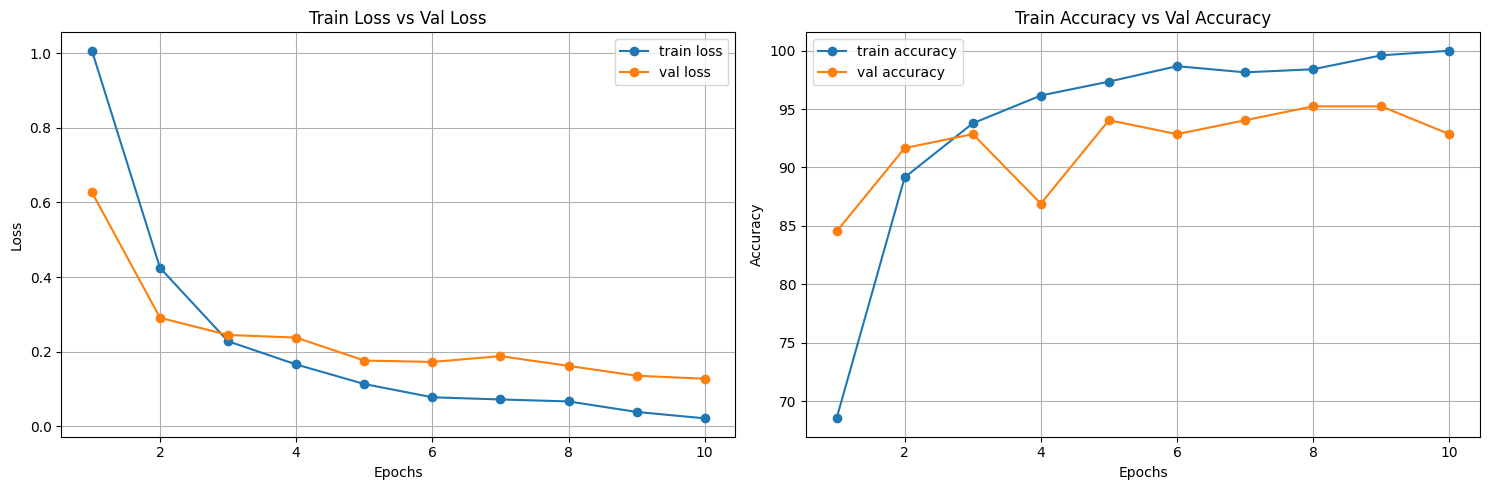

In [ ]:
plot_loss_acc(train_loss_3, val_loss_3, train_acc_3, val_acc_3)

In [33]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_4 = optim.Adam(model.parameters(), lr = 1e-4)
epochs = 10

In [34]:
train_loss_4, train_acc_4, val_loss_4, val_acc_4 = run_model(model, train_loader, val_loader, optimizer_4, criterion, epochs, device)

Epoch[1/10]------ accuracy: 77.38% ------ loss:0.69------ val_accuracy: 90.48% ------ val_loss: 0.34
Epoch[2/10]------ accuracy: 93.12% ------ loss:0.26------ val_accuracy: 96.43% ------ val_loss: 0.20
Epoch[3/10]------ accuracy: 95.37% ------ loss:0.18------ val_accuracy: 96.43% ------ val_loss: 0.15
Epoch[4/10]------ accuracy: 97.88% ------ loss:0.09------ val_accuracy: 97.62% ------ val_loss: 0.09
Epoch[5/10]------ accuracy: 99.21% ------ loss:0.06------ val_accuracy: 97.62% ------ val_loss: 0.12
Epoch[6/10]------ accuracy: 99.74% ------ loss:0.03------ val_accuracy: 95.24% ------ val_loss: 0.13
Epoch[7/10]------ accuracy: 99.74% ------ loss:0.03------ val_accuracy: 95.24% ------ val_loss: 0.19
Epoch[8/10]------ accuracy: 96.96% ------ loss:0.10------ val_accuracy: 86.90% ------ val_loss: 0.34
Epoch[9/10]------ accuracy: 98.54% ------ loss:0.06------ val_accuracy: 96.43% ------ val_loss: 0.12
Epoch[10/10]------ accuracy: 99.87% ------ loss:0.02------ val_accuracy: 96.43% ------ val_

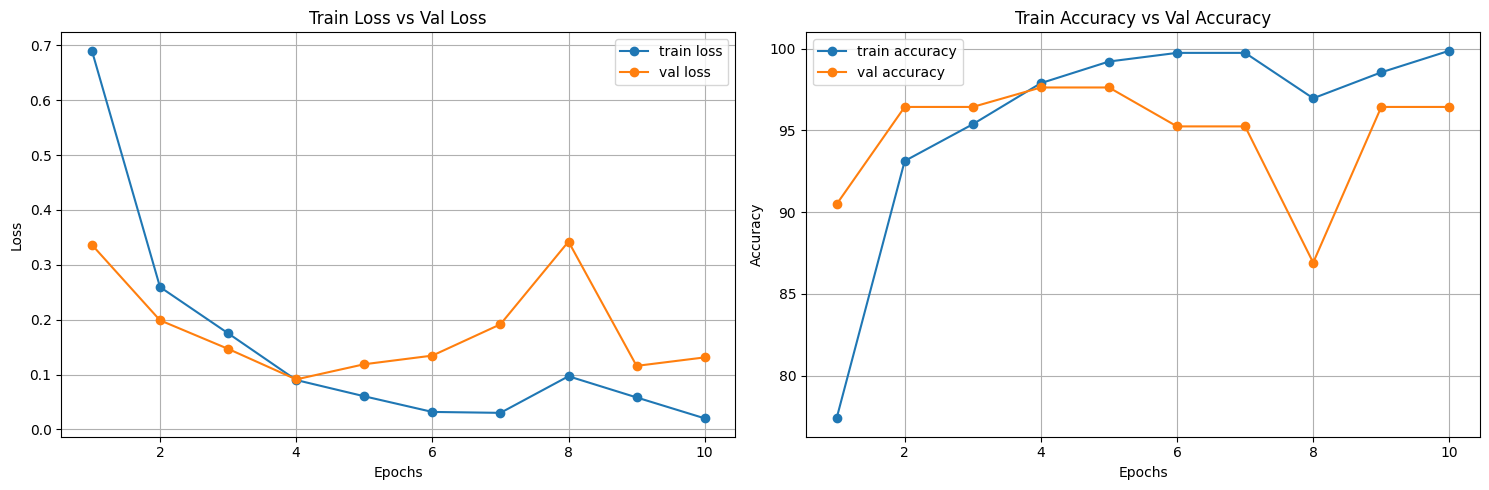

In [35]:
plot_loss_acc(train_loss_4, val_loss_4, train_acc_4, val_acc_4)

<h1 style="color:#D40078; font-weight:bold;">DenseNet121:</h1>  

In [ ]:
train_X = [prepared_ds ["train"][i]['pixel_values'] for i in range(len(prepared_ds ["train"]))]
train_X = torch.stack([torch.tensor(x).clone().detach() for x in train_X])
train_X = train_X.permute(0, 2, 3, 1)
train_X = train_X.numpy()

val_X = [prepared_ds ["validation"][i]["pixel_values"] for i in range(len(prepared_ds ["validation"]))]
val_X = torch.stack([torch.tensor(x).clone().detach() for x in val_X])
val_X = val_X.permute(0, 2, 3, 1)
val_X = val_X.numpy()

train_y = [prepared_ds ["train"][i]["labels"] for i in range(len(prepared_ds ["train"]))]
train_y = np.stack([y.detach().cpu().numpy() for y in train_y])

val_y = [prepared_ds ["validation"][i]["labels"] for i in range(len(prepared_ds ["validation"]))]
val_y = np.stack([y.detach().cpu().numpy() for y in val_y])

In [ ]:
model_5 = keras.applications.DenseNet121(
    include_top=False,
    weights=None,
    input_shape=(224, 224, 3),
)

In [ ]:
model_5.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
x = model_5.output
average_pooling = GlobalAveragePooling2D()(x)
dense = Dense(1024, activation="relu")(average_pooling)
predictions = Dense(4, activation="softmax")(dense)

model_5 = Model(inputs=model_5.input, outputs=predictions)

for layer in model_5.layers:
    layer.trainable = True

In [ ]:
model_5.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 8,091,204 (30.87 MB)

 Trainable params: 8,007,556 (30.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
model_5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model_5.fit(train_X, train_y, validation_data=(val_X, val_y), batch_size=16, epochs=10)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.4829 - loss: 1.4582 - val_accuracy: 0.3571 - val_loss: 6.1285
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.6630 - loss: 0.8544 - val_accuracy: 0.2738 - val_loss: 23.7684
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.7176 - loss: 0.7389 - val_accuracy: 0.6071 - val_loss: 2.2015
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.6793 - loss: 0.7772 - val_accuracy: 0.3690 - val_loss: 1.6960
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.7352 - loss: 0.6525 - val_accuracy: 0.6548 - val_loss: 0.8757
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.7595 - loss: 0.6061 - val_accuracy: 0.6071 - val_loss: 1.0447
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.7787 - loss: 0.5949 - val_accuracy: 0.4405 - val_loss: 2.5817
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.7564 - loss: 0.6410 - val_accuracy

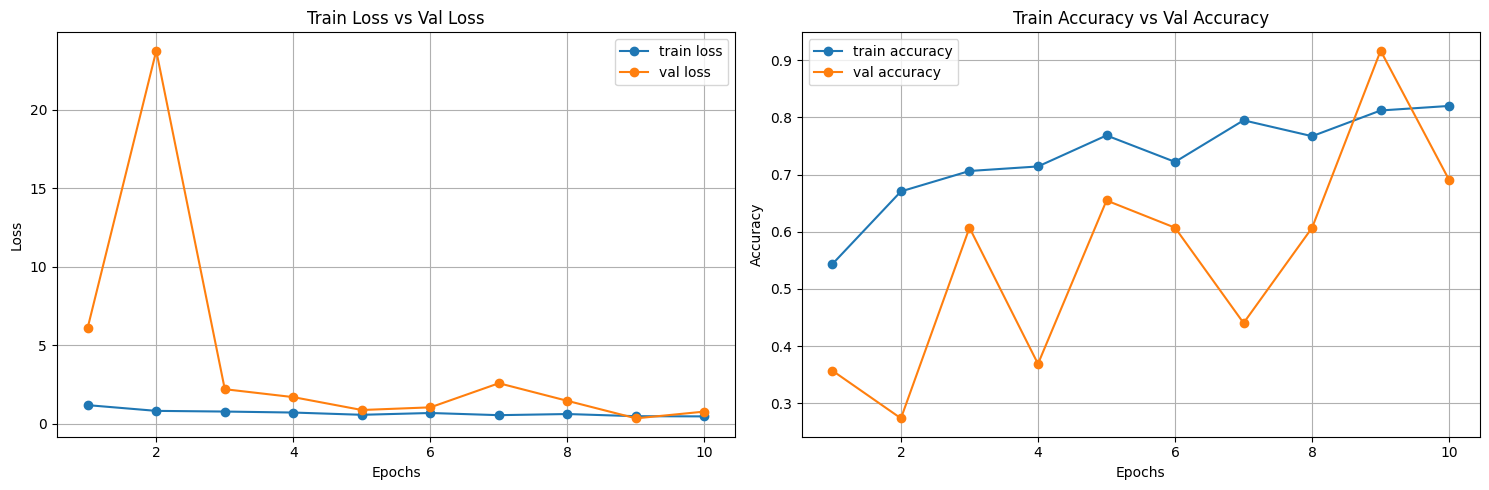

In [ ]:
plot_loss_acc(history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy'])

In [ ]:
def cnn_model_classifier_layer_trainable(model):
  model6 = copy.deepcopy(model)
  x = model6.output
  average_pooling = GlobalAveragePooling2D()(x)
  dense = Dense(1024, activation="relu")(average_pooling)
  predictions = Dense(4, activation="softmax")(dense)

  model6 = Model(inputs=model6.input, outputs=predictions)

  for layer in model6.layers:
      layer.trainable = False
  for layer in model6.layers[-3:]:
    layer.trainable = True
  return model6



In [ ]:
model_cnn = keras.applications.DenseNet121(
    include_top=False,
    weights=None,
    input_shape=(224, 224, 3),
)

In [ ]:
model_6 = cnn_model_classifier_layer_trainable(model_cnn)

In [ ]:
model_6.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_2 = model_6.fit(train_X, train_y, validation_data=(val_X, val_y), batch_size=16, epochs=10)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 444ms/step - accuracy: 0.2477 - loss: 1.3902 - val_accuracy: 0.2619 - val_loss: 1.3713
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.2800 - loss: 1.3756 - val_accuracy: 0.3690 - val_loss: 1.3561
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.3382 - loss: 1.3477 - val_accuracy: 0.4762 - val_loss: 1.3167
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3719 - loss: 1.3250 - val_accuracy: 0.3690 - val_loss: 1.2964
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3632 - loss: 1.2939 - val_accuracy: 0.3690 - val_loss: 1.2794
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4330 - loss: 1.2435 - val_accuracy: 0.4762 - val_loss: 1.2005
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4390 - loss: 1.2136 - val_accuracy: 0.5000 - val_loss: 1.1637
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5023 - loss: 1.1638 - val_accuracy: 0.5119 

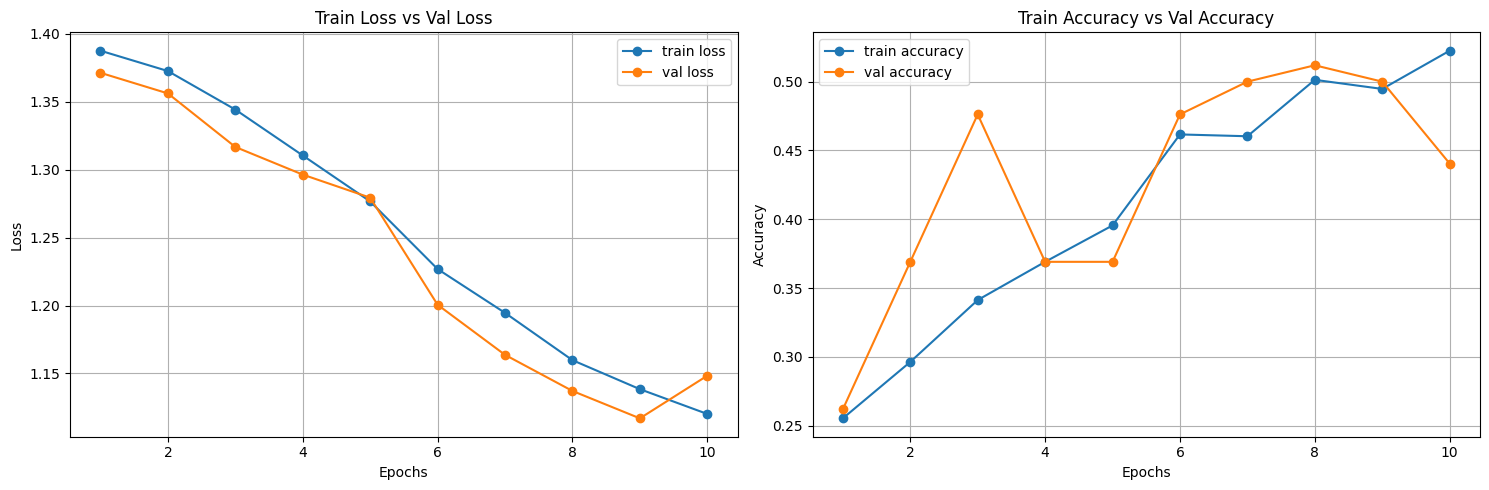

In [ ]:
plot_loss_acc(history_2.history['loss'], history_2.history['val_loss'], history_2.history['accuracy'], history_2.history['val_accuracy'])